# F1 Tire Degradation Analysis

This notebook contains clean, production-ready functions for F1 tire degradation analysis using FastF1 data.

## Features:
- **Gap Calculations**: Calculate gaps to car ahead for dirty air analysis
- **Fuel Corrections**: Apply realistic fuel load corrections to lap times
- **Dirty Air Modeling**: Convert gaps to dirty air penalty features
- **Clean Lap Filtering**: Filter to representative laps only
- **Complete Pipeline**: One-function processing from raw session to analysis-ready data

## Usage:
```python
session = fastf1.get_session(2024, "Bahrain", "R")
session.load(telemetry=False, weather=True)
processed_laps = process_race_for_tire_analysis(session)
```

## Imports and Setup

In [1]:
import fastf1
import fastf1.plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("F1 Tire Degradation Analysis Environment Ready! 🏎️")

F1 Tire Degradation Analysis Environment Ready! 🏎️


## Core Functions

These functions provide a complete pipeline for processing F1 race data for tire degradation analysis.

In [ ]:
def calculate_gaps_to_car_ahead(laps):
    """
    Calculate gaps to car ahead for each lap based on position and timing data.
    This replicates the gap calculation logic for dirty air analysis.
    
    Parameters:
    - laps: FastF1 laps dataframe (raw session.laps)
    
    Returns:
    - DataFrame with gap columns added: Start_Gap, S1_Gap, S2_Gap, S3_Gap, Avg_Gap
    """
    # Work with a copy to avoid modifying original
    laps_with_gaps = laps.copy()
    
    # Add LapTimeSeconds if not present
    if 'LapTimeSeconds' not in laps_with_gaps.columns:
        laps_with_gaps['LapTimeSeconds'] = laps_with_gaps['LapTime'].dt.total_seconds()
    
    # Get accurate laps for creating the "car ahead" reference
    accurate_laps_for_ahead = laps_with_gaps[laps_with_gaps['IsAccurate'] == True].copy()
    
    # Create car_ahead dataframe with timing data
    car_ahead = accurate_laps_for_ahead[['LapStartTime', 'Position', 'LapNumber', 
                                       'Sector1SessionTime', 'Sector2SessionTime', 
                                       'Sector3SessionTime']].copy()
    
    # Create merge key for car ahead (position + 1 = car we're following)
    car_ahead['MergeKey'] = car_ahead['Position'] + 1
    
    # Rename columns to indicate they're for the car ahead
    car_ahead.rename(columns={
        'LapStartTime': 'Start_Ahead', 
        'Sector1SessionTime': 'S1_Ahead', 
        'Sector2SessionTime': 'S2_Ahead', 
        'Sector3SessionTime': 'S3_Ahead'
    }, inplace=True)
    
    # Merge with main laps data to get car ahead timing
    laps_with_gaps = laps_with_gaps.merge(
        car_ahead, 
        left_on=['Position', 'LapNumber'], 
        right_on=['MergeKey', 'LapNumber'], 
        how='left'
    )
    
    # Calculate gaps in seconds
    laps_with_gaps['Start_Gap'] = (laps_with_gaps['LapStartTime'] - laps_with_gaps['Start_Ahead']).dt.total_seconds()
    laps_with_gaps['S1_Gap'] = (laps_with_gaps['Sector1SessionTime'] - laps_with_gaps['S1_Ahead']).dt.total_seconds()
    laps_with_gaps['S2_Gap'] = (laps_with_gaps['Sector2SessionTime'] - laps_with_gaps['S2_Ahead']).dt.total_seconds()
    laps_with_gaps['S3_Gap'] = (laps_with_gaps['Sector3SessionTime'] - laps_with_gaps['S3_Ahead']).dt.total_seconds()
    
    # Calculate average gap across sectors
    laps_with_gaps['Avg_Gap'] = (laps_with_gaps['S1_Gap'] + laps_with_gaps['S2_Gap'] + laps_with_gaps['S3_Gap']) / 3
    
    # Clean up negative gaps (when we're ahead of the reference car)
    laps_with_gaps.loc[laps_with_gaps['Start_Gap'] < 0, 'Start_Gap'] = np.nan
    laps_with_gaps.loc[laps_with_gaps['S1_Gap'] < 0, 'S1_Gap'] = np.nan
    laps_with_gaps.loc[laps_with_gaps['S2_Gap'] < 0, 'S2_Gap'] = np.nan
    laps_with_gaps.loc[laps_with_gaps['S3_Gap'] < 0, 'S3_Gap'] = np.nan
    
    return laps_with_gaps


def compute_dirty_air_feature(df, gap_col='Start_Gap'):
    """
    Convert gap (seconds) to a dirty-air feature using the Start_Gap column.
    We use a smooth transform: small gaps -> strong dirty-air penalty.
    Returns 'dirty_air' where higher = worse (more lap time lost).
    
    Parameters:
    - df: DataFrame with gap data
    - gap_col: Column name for gap data (default 'Start_Gap')
    
    Returns:
    - DataFrame with 'dirty_air' column added (0-1 scale, 1=worst penalty)
    """
    out = df.copy()
    # Use the Start_Gap column that was calculated earlier, or fall back to provided gap_col
    if 'Start_Gap' in out.columns:
        g = out['Start_Gap'].fillna(999.0)  # No car ahead -> large gap (clean air)
    elif gap_col in out.columns:
        g = out[gap_col].fillna(999.0)
    else:
        raise ValueError(f"Neither 'Start_Gap' nor '{gap_col}' found in dataframe")
    
    # Example transform: inverse gap up to a clamp
    clamp = 5.0   # gaps > clamp treated as "clean air"
    g_clamped = np.minimum(g, clamp)
    # Inverse with smoothness; shift to 0..1
    out['dirty_air'] = (1.0 - (g_clamped / clamp)) ** 2   # 1 = bumper-to-bumper, 0 = >clamp clean
    return out


def fuel_correct_lap_time(df, total_fuel_load=95, fuel_pace_adjustment=0.03, lap_time_col='LapTimeSeconds'):
    """
    Subtract estimated fuel-related time from lap_time based on race progression.
    Assumes steady fuel burn from total_fuel_load kg to ~5kg at race end.
    
    Parameters:
    - df: DataFrame with lap time data
    - total_fuel_load: Starting fuel load in kg (default 95kg, ending ~5kg = 90kg burned)
    - fuel_pace_adjustment: Time loss per kg of fuel (default 0.03s/kg)
    - lap_time_col: Column name for lap times in seconds
    
    Returns:
    - DataFrame with 'fuel_load', 'fuel_time_loss', and 'lap_time_fuel_corrected' columns
    """
    out = df.copy()
    
    # Calculate fuel load based on lap progression within each driver's stint
    # Group by driver to handle each driver separately
    def calculate_fuel_for_driver(driver_df):
        driver_df = driver_df.copy()
        lap_count = len(driver_df)
        
        # Calculate fuel per lap (90kg burned over race distance)
        fuel_per_lap = total_fuel_load / lap_count if lap_count > 0 else 0
        
        # Fuel load decreases linearly: starts high, ends low
        # Create fuel load based on remaining laps (reverse order)
        remaining_laps = np.arange(lap_count, 0, -1)
        driver_df['fuel_load'] = remaining_laps * fuel_per_lap + 5  # +5kg minimum fuel
        
        return driver_df
    
    # Apply fuel calculation per driver
    if 'Driver' in out.columns:
        out = out.groupby('Driver', group_keys=False).apply(calculate_fuel_for_driver)
    else:
        # If no driver column, treat as single driver
        lap_count = len(out)
        fuel_per_lap = 90 / lap_count if lap_count > 0 else 0
        remaining_laps = np.arange(lap_count, 0, -1)
        out['fuel_load'] = remaining_laps * fuel_per_lap + 5
    
    # Calculate time loss due to fuel weight
    out['fuel_time_loss'] = out['fuel_load'] * fuel_pace_adjustment
    
    # Create fuel-corrected lap time
    if lap_time_col not in out.columns:
        # Try to create LapTimeSeconds if LapTime exists
        if 'LapTime' in out.columns:
            out['LapTimeSeconds'] = out['LapTime'].dt.total_seconds()
        else:
            raise ValueError(f"Column '{lap_time_col}' not found and cannot create it")
    
    out['lap_time_fuel_corrected'] = out[lap_time_col] - out['fuel_time_loss']
    
    return out


def filter_clean_laps(df, is_accurate_col='IsAccurate', min_speed=80.0, speed_col='AverageSpeed'):
    """
    Filter laps to only include "clean" laps for analysis.
    
    Criteria:
    - is_accurate_col == True (excludes outlaps, safety car, etc.)
    - speed_col >= min_speed (if column exists)
    
    Parameters:
    - df: DataFrame with lap data
    - is_accurate_col: Column name for accuracy flag
    - min_speed: Minimum average speed threshold
    - speed_col: Column name for speed data
    
    Returns:
    - Filtered DataFrame with only clean laps
    """
    out = df.copy()
    
    # Always filter by accuracy
    mask = (out[is_accurate_col] == True)
    
    # Add speed filter if column exists
    if speed_col in out.columns:
        mask = mask & (out[speed_col] >= min_speed)
    
    return out[mask]


def process_race_for_tire_analysis(session, include_weather=True):
    """
    Complete pipeline to process a race session for tire degradation analysis.
    Takes raw session and returns clean laps with all corrections applied.
    
    This is the main function that combines all the processing steps.
    
    Parameters:
    - session: FastF1 session object (already loaded with session.load())
    - include_weather: Whether to merge weather data (default True)
    
    Returns:
    - DataFrame ready for tire degradation analysis with columns:
      * lap_time_fuel_corrected: Fuel-corrected lap times
      * dirty_air: Dirty air penalty feature (0-1)
      * fuel_load: Calculated fuel load per lap
      * Start_Gap, S1_Gap, etc.: Gap timing to car ahead
      * Weather data (if available): TrackTemp, AirTemp, etc.
    """
    print("🏎️  Processing race data for tire analysis...")
    
    # Step 1: Get raw laps
    laps = session.laps.copy()
    print(f"📊 Starting with {len(laps)} total laps")
    
    # Step 2: Calculate gaps to car ahead
    print("⏱️  Calculating gaps to car ahead...")
    laps = calculate_gaps_to_car_ahead(laps)
    
    # Step 3: Merge weather data if available and requested
    if include_weather and hasattr(session, 'weather_data') and session.weather_data is not None:
        print("🌡️  Merging weather data...")
        laps = laps.sort_values(by='Time')
        weather_data = session.weather_data.sort_values(by='Time')
        laps = pd.merge_asof(laps, weather_data, left_on='Time', right_on='Time', direction='nearest')
    
    # Step 4: Filter to clean laps only
    print("🧹 Filtering to clean laps...")
    laps = filter_clean_laps(laps)
    print(f"✅ After filtering: {len(laps)} clean laps")
    
    # Step 5: Apply fuel correction
    print("⛽ Applying fuel corrections...")
    laps = fuel_correct_lap_time(laps)
    
    # Step 6: Add dirty air feature
    print("💨 Computing dirty air features...")
    laps = compute_dirty_air_feature(laps)
    
    print("🎉 Processing complete!")
    print(f"📈 Final dataset: {len(laps)} laps from {laps['Driver'].nunique()} drivers")
    
    return laps

print("✅ All functions loaded successfully!")

✅ All functions loaded successfully!


## Usage Examples

Here are examples of how to use the functions for tire degradation analysis.

In [3]:
# Example 1: Complete Pipeline (Recommended)
# This is the easiest way to get analysis-ready data

print("=== EXAMPLE 1: Complete Pipeline ===")
print("Loading 2024 Bahrain Grand Prix...")

session = fastf1.get_session(2024, "Bahrain", "R")
session.load(telemetry=False, weather=True)

# Process the entire race with one function call
processed_laps = process_race_for_tire_analysis(session, include_weather=True)

print("\n📊 Sample of processed data:")
display_cols = ['Driver', 'LapNumber', 'LapTimeSeconds', 'lap_time_fuel_corrected', 
               'fuel_load', 'Start_Gap', 'dirty_air']
print(processed_laps[display_cols].head(10))

req         WARNING 	DEFAULT CACHE ENABLED! (1.33 GB) /Users/emccauley6/Library/Caches/fastf1
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_

=== EXAMPLE 1: Complete Pipeline ===
Loading 2024 Bahrain Grand Prix...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']


🏎️  Processing race data for tire analysis...
📊 Starting with 1129 total laps
⏱️  Calculating gaps to car ahead...
🌡️  Merging weather data...
🧹 Filtering to clean laps...
✅ After filtering: 1024 clean laps
⛽ Applying fuel corrections...
💨 Computing dirty air features...
🎉 Processing complete!
📈 Final dataset: 1024 laps from 20 drivers

📊 Sample of processed data:
   Driver  LapNumber  LapTimeSeconds  lap_time_fuel_corrected  fuel_load  \
20    VER        2.0          96.296                   93.446       95.0   
21    LEC        2.0          96.862                   94.012       95.0   
22    RUS        2.0          96.635                   93.785       95.0   
23    PER        2.0          96.541                   93.691       95.0   
24    SAI        2.0          97.236                   94.386       95.0   
25    ALO        2.0          98.020                   95.170       95.0   
26    NOR        2.0          98.010                   95.160       95.0   
27    PIA        2.0     

In [4]:
# Example 2: Step-by-step usage (for customization)
print("=== EXAMPLE 2: Step-by-step Processing ===")

# Start with raw laps
raw_laps = session.laps.copy()
print(f"Raw laps: {len(raw_laps)}")

# Step 1: Calculate gaps
laps_with_gaps = calculate_gaps_to_car_ahead(raw_laps)
print(f"Gaps calculated for {len(laps_with_gaps)} laps")

# Step 2: Filter clean laps
clean_laps = filter_clean_laps(laps_with_gaps)
print(f"Clean laps: {len(clean_laps)}")

# Step 3: Apply fuel correction
fuel_corrected = fuel_correct_lap_time(clean_laps)
print(f"Fuel correction applied")

# Step 4: Add dirty air feature
final_data = compute_dirty_air_feature(fuel_corrected)
print(f"Dirty air features added")

print("\n✅ Step-by-step processing complete!")

=== EXAMPLE 2: Step-by-step Processing ===
Raw laps: 1129
Gaps calculated for 1129 laps
Clean laps: 1024
Fuel correction applied
Dirty air features added

✅ Step-by-step processing complete!


In [5]:
# Example 3: Analyze specific driver
print("=== EXAMPLE 3: Single Driver Analysis ===")

# Focus on Verstappen's data
verstappen_data = processed_laps[processed_laps['Driver'] == 'VER'].copy()

print(f"Verstappen: {len(verstappen_data)} clean laps")
print("\nFuel load progression:")
print(verstappen_data[['LapNumber', 'fuel_load', 'fuel_time_loss', 'lap_time_fuel_corrected']].head(10))

print("\nDirty air situations (gaps < 2 seconds):")
dirty_air_laps = verstappen_data[verstappen_data['Start_Gap'] < 2.0]
if len(dirty_air_laps) > 0:
    print(dirty_air_laps[['LapNumber', 'Start_Gap', 'dirty_air', 'LapTimeSeconds']].head())
else:
    print("No significant dirty air situations found")

=== EXAMPLE 3: Single Driver Analysis ===
Verstappen: 52 clean laps

Fuel load progression:
     LapNumber  fuel_load  fuel_time_loss  lap_time_fuel_corrected
20         2.0  95.000000        2.850000                93.446000
40         3.0  93.269231        2.798077                93.954923
60         4.0  91.538462        2.746154                93.900846
80         5.0  89.807692        2.694231                94.478769
100        6.0  88.076923        2.642308                94.449692
120        7.0  86.346154        2.590385                94.447615
140        8.0  84.615385        2.538462                94.485538
160        9.0  82.884615        2.486538                94.742462
180       10.0  81.153846        2.434615                94.525385
200       11.0  79.423077        2.382692                94.702308

Dirty air situations (gaps < 2 seconds):
No significant dirty air situations found


## Data Visualization Examples

Quick visualizations to understand the processed data.

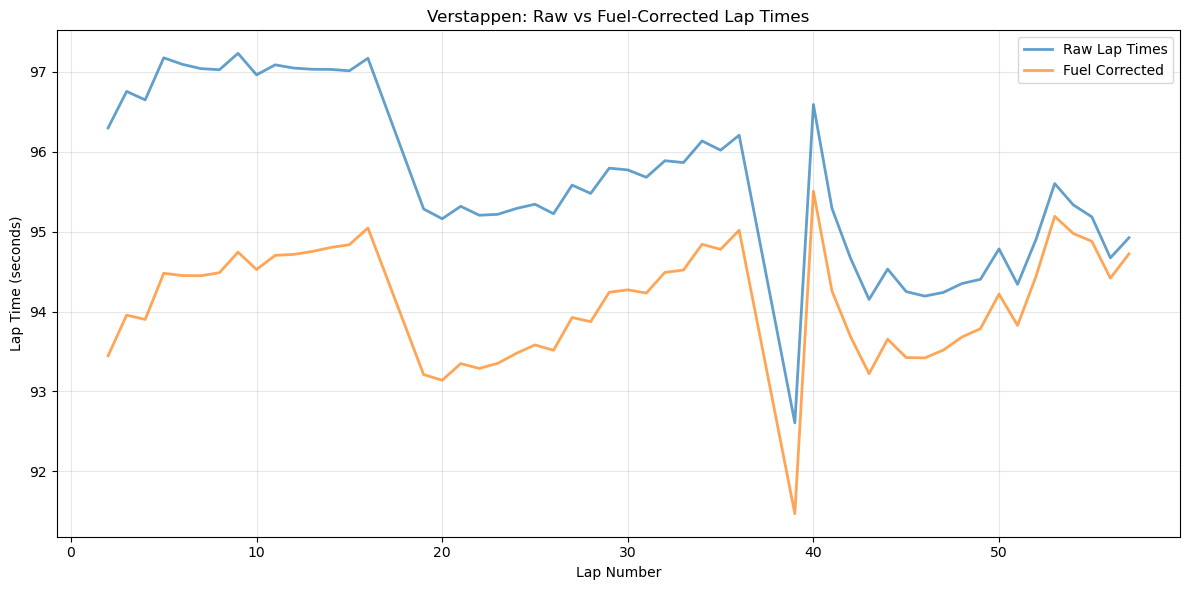

Average fuel correction: 1.526 seconds


In [6]:
# Visualization 1: Fuel-corrected vs Raw lap times
plt.figure(figsize=(12, 6))

# Plot for a specific driver
driver_data = processed_laps[processed_laps['Driver'] == 'VER'].copy()

plt.plot(driver_data['LapNumber'], driver_data['LapTimeSeconds'], 
         label='Raw Lap Times', alpha=0.7, linewidth=2)
plt.plot(driver_data['LapNumber'], driver_data['lap_time_fuel_corrected'], 
         label='Fuel Corrected', alpha=0.7, linewidth=2)

plt.xlabel('Lap Number')
plt.ylabel('Lap Time (seconds)')
plt.title('Verstappen: Raw vs Fuel-Corrected Lap Times')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average fuel correction: {driver_data['fuel_time_loss'].mean():.3f} seconds")

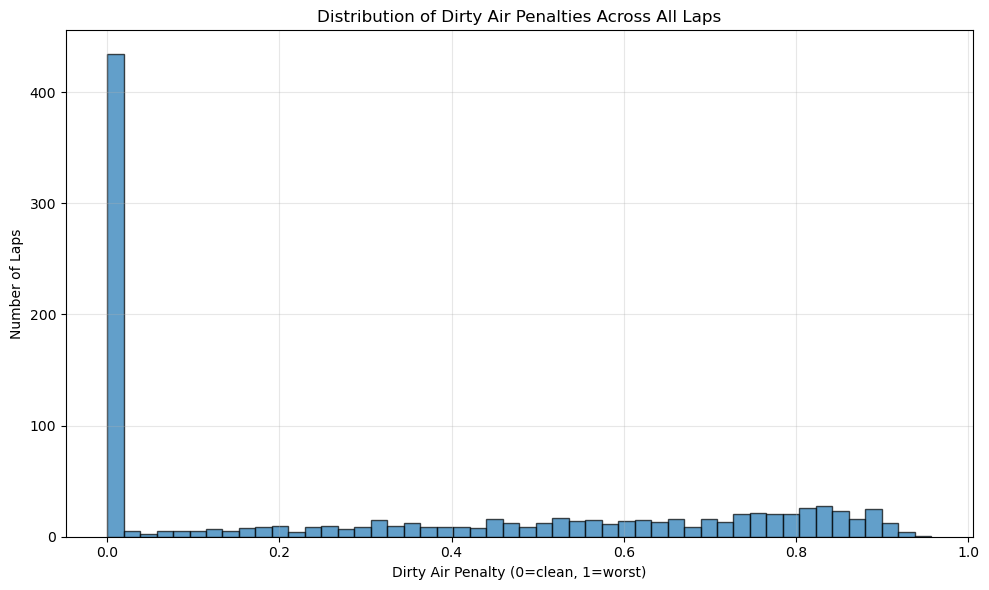

Clean air laps (penalty < 0.2): 47.8%


In [7]:
# Visualization 2: Dirty air distribution
plt.figure(figsize=(10, 6))

# Plot dirty air distribution across all drivers
dirty_air_data = processed_laps['dirty_air'].dropna()

plt.hist(dirty_air_data, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Dirty Air Penalty (0=clean, 1=worst)')
plt.ylabel('Number of Laps')
plt.title('Distribution of Dirty Air Penalties Across All Laps')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

clean_air_pct = (dirty_air_data < 0.2).mean() * 100
print(f"Clean air laps (penalty < 0.2): {clean_air_pct:.1f}%")

## Summary

This notebook provides a complete toolkit for F1 tire degradation analysis:

### Key Functions:
1. **`process_race_for_tire_analysis()`** - Main function for complete processing
2. **`calculate_gaps_to_car_ahead()`** - Calculate timing gaps for dirty air analysis  
3. **`fuel_correct_lap_time()`** - Apply realistic fuel load corrections
4. **`compute_dirty_air_feature()`** - Convert gaps to dirty air penalties
5. **`filter_clean_laps()`** - Filter to representative laps only

### Output Data Columns:
- `lap_time_fuel_corrected` - Fuel-corrected lap times
- `dirty_air` - Dirty air penalty (0-1 scale)
- `fuel_load` - Calculated fuel load per lap
- `Start_Gap`, `S1_Gap`, etc. - Timing gaps to car ahead
- Weather data (if available)

### Next Steps:
Use the processed data for:
- Tire degradation modeling
- Performance analysis
- Strategy optimization
- Driver comparisons

---
*Happy analyzing! 🏎️📊*